
# Cluster Analysis: Partitioning (Segmentation)

Create a set of functions that can be used together to segment satellite  images into similar regions using k-means clustering, and then create and apply a color mask to areas of water. Specifically:

1. Determine the best image pre-processing method that will do the best job of smoothing similar colors
    - sub-regions in satellite  images tend to have a lot of color variation / texture that can negatively impact the performance of segmentation when using something like k-means clustering
    - use scikit-image for this
2. Create a pre_process funcition that returns a pre-processed version of the image that has the following parameters
    - img : the input image
    - p : whatever parameter belongs to the method you chose from (1)
    - multichannel : Bool for whether or not the image has multiple channels (e.g. RGB)
        + only if necessary
3. Create one or more functions that together are used for segmenting an image using k-means clustering
4. Create a function to help automate the selection of parameters to use in the method from (1) and for k-means 
    - it should iterate over a set of 6 possible test parameter combinations
        + each combination is (pre-processing parameter, n_clusters for kmeans)
    - each iteration should segment the provided satellite image using the the given combination
    - return a single image that displays the segmented versions in a 3x2 grid
    - visually inspect the 6 versions and decide on the best combination to use
5. Use the parameters determined above to create a version of the original image that has a single-colored mask wherever water appears in the image

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from skimage.io import imread
from skimage.filters import gaussian
from sklearn.cluster import KMeans

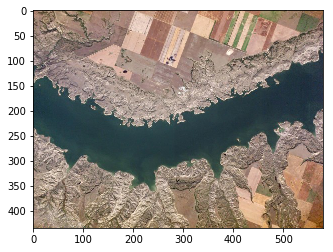

In [3]:
image = imread('./Segmentation/sat4.jpg')
plt.imshow(image);

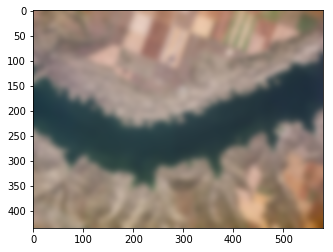

In [4]:
# part 1
filtered = gaussian(image, sigma=6, multichannel=True)
plt.imshow(filtered);

In [5]:
# part 2
def pre_process(img, sigma, multichannel=True):
    return gaussian(img, sigma=sigma, multichannel=multichannel)

In [6]:
# part 3
def segmentation(img, nclusters, multichannel=True):
    # get image dimensions
    imheight = img.shape[0]
    imwidth = img.shape[1]
    if multichannel:
        immulti = img.shape[2]
    else:
        immulti = 1
    # reshape image
    img_reshape = img.ravel().reshape(imwidth*imheight, immulti)
    # fit kmeans
    kmeans = KMeans(n_clusters=nclusters)
    kmeans.fit(img_reshape)
    return kmeans.labels_, kmeans.inertia_

def show_segmentation(img, labels):
    # get image dimensions
    imheight = img.shape[0]
    imwidth = img.shape[1]
    # create grid
    X, Y = np.meshgrid(np.arange(imwidth), np.arange(imheight))
    # scatterplot 
    fig, ax = plt.subplots()
    ax.scatter(x=X.ravel(), y=Y.ravel(), c=labels)
    ax.set_ylim(imheight-1, 0)
    return fig

In [7]:
imlabels, inertia = segmentation(filtered, nclusters=5)

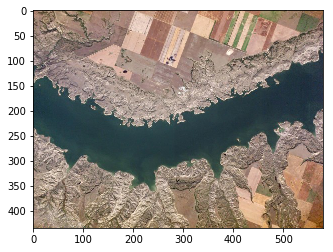

In [8]:
plt.imshow(image);

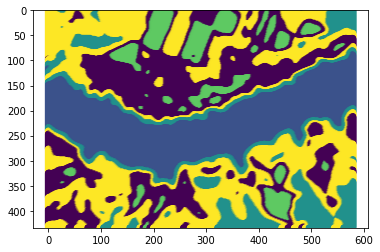

In [9]:
show_segmentation(image, imlabels);

In [10]:
# part 4
def parameter_selection(img, nclusters, sigmas, multichannel=True, verbose=False):
    inertias = {}
    all_labels = {}
    for s in sigmas:
        filtered = pre_process(img, sigma=s, multichannel=multichannel)
        for n in nclusters:
            labels, inertia = segmentation(filtered, nclusters=n, multichannel=multichannel)
            inertias[(s, n)] = inertia
            all_labels[(s, n)] = labels
            if verbose:
                print('sigma={} and {} clusters trained.'.format(s, n))
            
    # get image dimensions
    imheight = img.shape[0]
    imwidth = img.shape[1]
    # create grid
    X, Y = np.meshgrid(np.arange(imwidth), np.arange(imheight))
    # scatterplot
    fig, ax = plt.subplots(3, 2, figsize=(10, 16))
    for k, key in enumerate(all_labels):
        j = k%2
        i = int((k-j)/2)
        ax[i, j].scatter(x=X.ravel(), y=Y.ravel(), c=all_labels[key])
        ax[i, j].set_ylim(imheight-1, 0)
        ax[i, j].set_title('$\sigma={}$ and {} clusters'.format(key[0], key[1]));
    return all_labels, inertias, fig

sigma=3 and 4 clusters trained.
sigma=3 and 5 clusters trained.
sigma=3 and 6 clusters trained.
sigma=6 and 4 clusters trained.
sigma=6 and 5 clusters trained.
sigma=6 and 6 clusters trained.


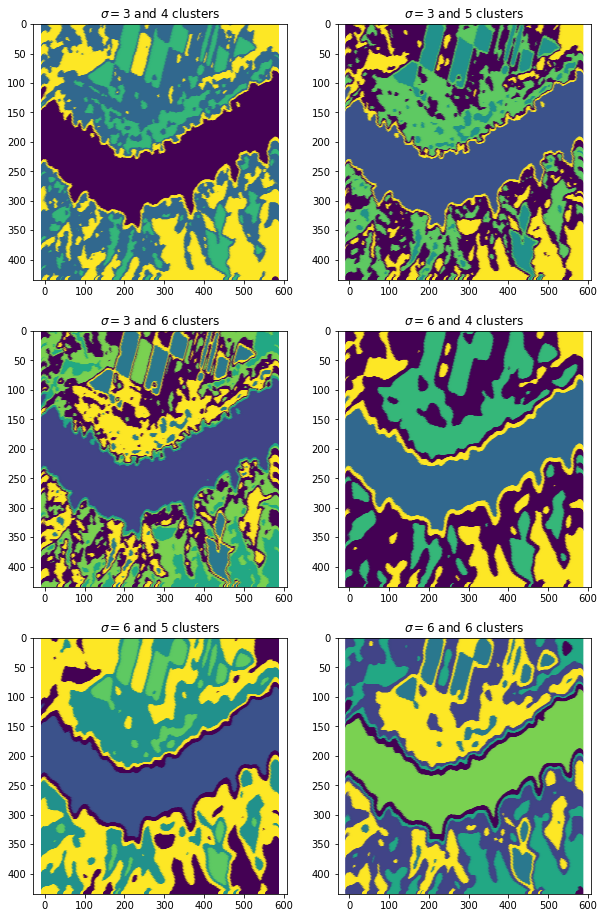

In [11]:
nclusters = [4, 5, 6]
sigmas = [3, 6]

labels, inertias, fig = parameter_selection(image, nclusters=nclusters, sigmas=sigmas, verbose=True)

In [12]:
inertias

{(3, 4): 1645.2723838678085,
 (3, 5): 1237.8328103464603,
 (3, 6): 1042.4132496075617,
 (6, 4): 1604.0965839139858,
 (6, 5): 1250.7511039771198,
 (6, 6): 1022.97068175263}

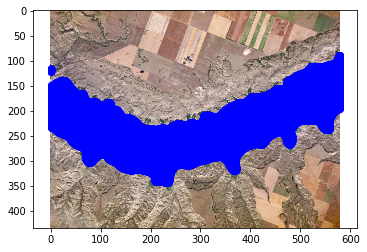

In [43]:
# part 6
# sigma = 6 and 4 clusters
params = (6, 4)
imheight = image.shape[0]
imwidth = image.shape[1]
lab = 1

# create grid
X, Y = np.meshgrid(np.arange(imwidth), np.arange(imheight))

plt.imshow(image)
plt.scatter(x=X.ravel()[labels[params]==lab], y=Y.ravel()[labels[params]==lab], c='b');

# Cluster Analysis: Target Study (Young People Survey) using agglomerative clustering

The dataset provided can be summarized as follows:

In 2013, students of the Statistics class at FSEV UK were asked to invite their friends to participate in this survey.

* The data file (responses.csv) consists of 1010 rows and 150 columns (139 integer and 11 categorical).
* For convenience, the original variable names were shortened in the data file. See the columns.csv file if you want to match the data with the original names.
* The data contain missing values.
* The survey was presented to participants in both electronic and written form.
* The original questionnaire was in Slovak language and was later translated into English.
* All participants were of Slovakian nationality, aged between 15-30.
* Numerical columns are primarily in range [1,5], except for values like weight and height.

Your task is to use agglomerative (hierarchical) cluster analysis to analyze this data. Specifically:

1. Modify the original data
    - Remove any categorical variables from the data
        - categorical doesn't work with this clustering method
        - we aren't concerned with creating dummy vars
    - Add a new column for gender, but make it binary
    - Remove any rows with null values
2. Use scipy to cluster and create a dendrogram of the cluster hierarchy for the data
    - use the ward method
    - exclude gender for now
    - plot the dendrogram
    - determine a good cutoff value
    - re-plot the dendrogram with a line for the cutoff and determine the number of clusters this gives
3. Create a new dendrogram that truncates using the determined number of clusters and show number of points per cluster
    - hint: check the truncate_mode options
4. Use the scipy `hierarchy.fcluster` method to get cluster labels for 16 clusters from the data
    - hint: threshold
    - create a column for the labels in the data
    - compare the class distributions between genders
    - reset the threshold and create a new set of labels that will give only two classes
        - add this as a second column for labels
    - compare the distributions of these two classes between genders
        - does it seem that the two top-level clusters are gender-specific?

In [14]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [15]:
# part 1
responses = pd.read_csv('./Targeted/responses.csv')
# new gender column, 0=female 1=male
responses['gender'] = responses['Gender'].apply(lambda x: 0 if x=='female' else 1)
# drop categoricals
responses.drop(responses.columns[responses.dtypes=='object'], axis=1, inplace=True)
# drop rows with nas
responses.dropna(inplace=True)

In [16]:
# part 2
X = responses.drop('gender', axis=1).values
link = linkage(X, 'ward')

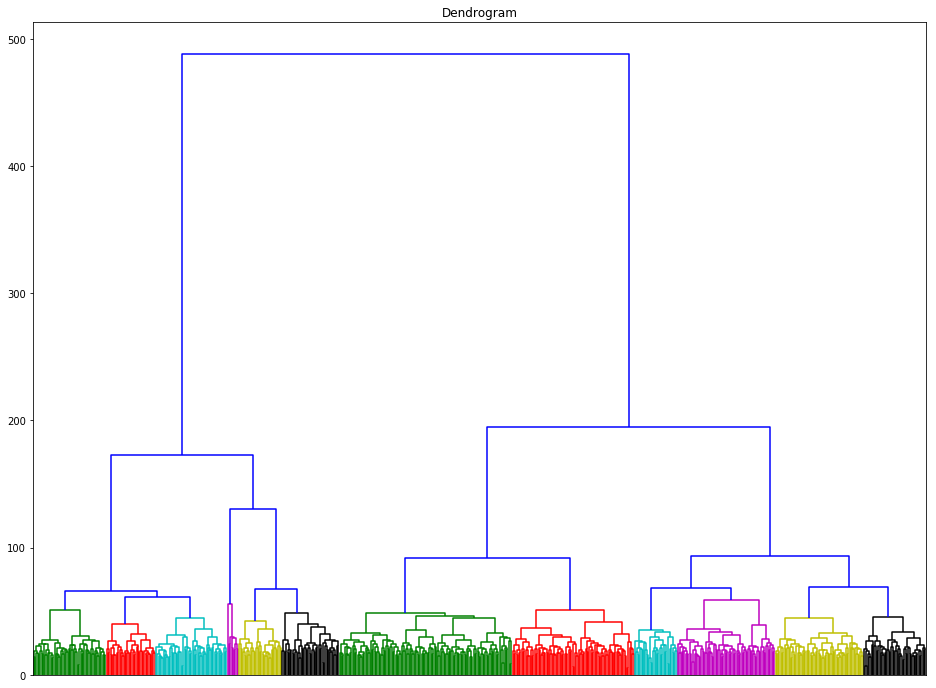

In [17]:
plt.figure(figsize=(16, 12))
ddata = dendrogram(link, no_labels=True, color_threshold=60)
plt.title('Dendrogram');

In [18]:
def get_ncluster(ddata, threshold):
    dcoords = np.array(ddata['dcoord']) # coordinates of vertical lines: bottom left, upper left, bottom right, upper right
    left_clusters = np.sum((dcoords[:, 0] <= threshold) & (dcoords[:, 1] >= threshold))
    right_clusters = np.sum((dcoords[:, 3] <= threshold) & (dcoords[:, 2] >= threshold))
    return left_clusters + right_clusters

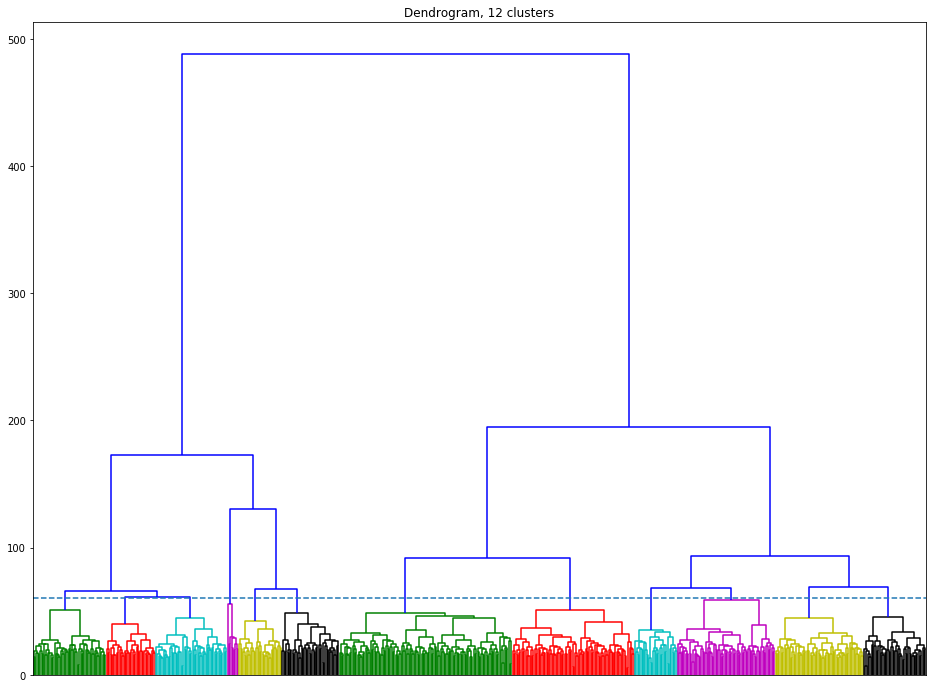

In [19]:
plt.figure(figsize=(16, 12))
ddata = dendrogram(link, no_labels=True, color_threshold=60)
nclust = get_ncluster(ddata, 60)
plt.axhline(y=60, linestyle='--')
plt.title('Dendrogram, {} clusters'.format(nclust));

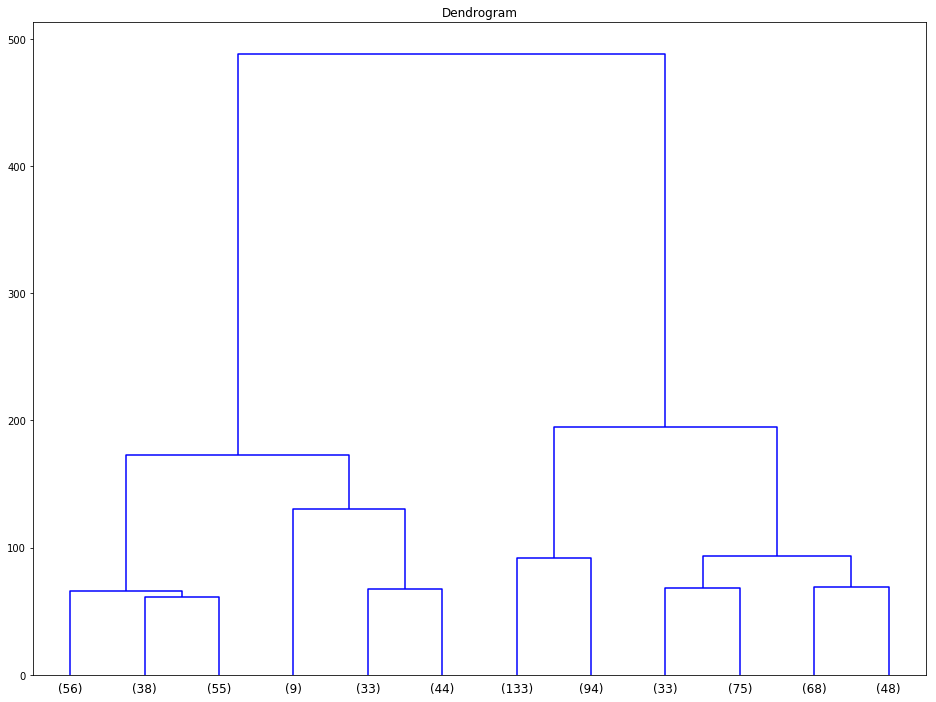

In [20]:
# part 3
plt.figure(figsize=(16, 12))
ddata = dendrogram(link, p=12, color_threshold=60, truncate_mode='lastp', show_leaf_counts=True)
plt.title('Dendrogram');

In [21]:
# part 4
responses['label16'] = fcluster(link, 16, criterion='maxclust')

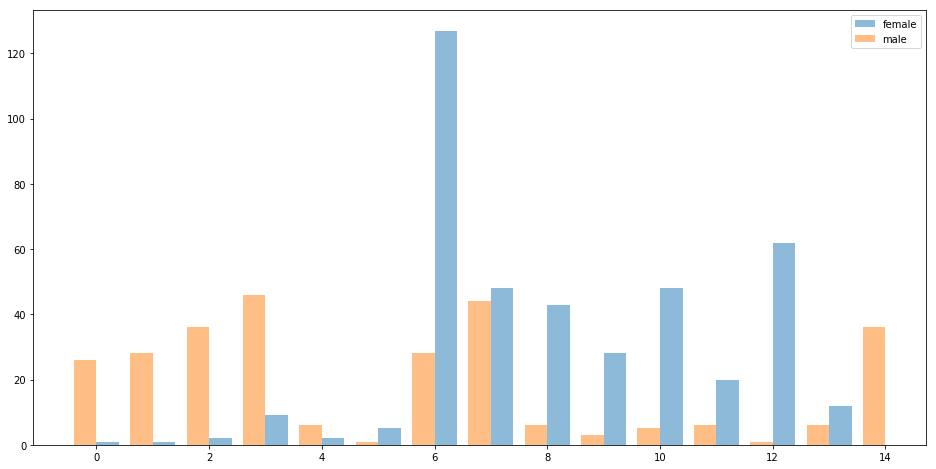

In [22]:
female = responses.loc[responses['gender']==0, 'label16'].value_counts().sort_index()
male = responses.loc[responses['gender']==1, 'label16'].value_counts().sort_index()
plt.figure(figsize=(16, 8))
plt.bar(np.arange(len(female)) + 0.2, female, width=0.4, alpha=0.5, label='female')
plt.bar(np.arange(len(male)) - 0.2, male, width=0.4, alpha=0.5, label='male')
plt.legend();

In [23]:
responses['label2'] = fcluster(link, 2, criterion='maxclust')

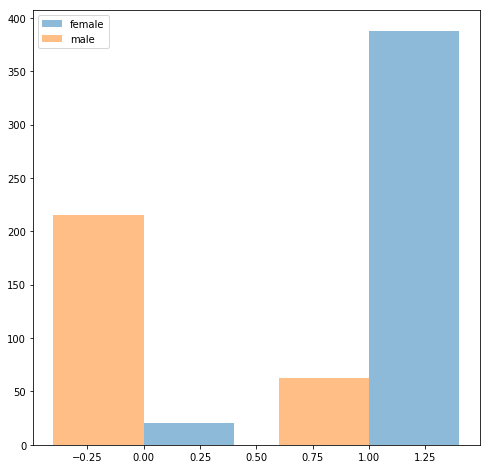

In [24]:
female = responses.loc[responses['gender']==0, 'label2'].value_counts().sort_index()
male = responses.loc[responses['gender']==1, 'label2'].value_counts().sort_index()
plt.figure(figsize=(8, 8))
plt.bar(np.arange(len(female)) + 0.2, female, width=0.4, alpha=0.5, label='female')
plt.bar(np.arange(len(male)) - 0.2, male, width=0.4, alpha=0.5, label='male')
plt.legend();

# Data Summarization / Color Quantization

Given a set of images, use k-means to perform color quantization to reduce the number of distinct colors in each image. Specifically

1. Create a quantize function that takes an image and the desired number of colors as parameters and
    - performs color quantization using k-means
        - reduce the number of colors in the image
    - return the color-reduced image
    - make sure it can handle both greyscale and multichannel images
    - run this function on the image titled bw.jpg and view the result
2. Create a batch_reduce function that takes a list of file names and number of desired colors as parameters and
    - imports/opens each image in the list of file names
    - uses the quantize function to reduce the number of colors in each image
    - saves the original and reduced images in separate folders
3. Run the batch_reduce on everything in the provided images folder and then compare original and reduced file sizes

In [3]:
import os
from scipy.misc import imsave

In [4]:
# part 1
def quantize(img, out_colors):
    # get image dimensions
    imheight = img.shape[0]
    imwidth = img.shape[1]
    if len(img.shape) == 3:
        immulti = img.shape[2]
    else:
        immulti = 1
    # reshape image
    img_reshape = img.ravel().reshape(imwidth*imheight, immulti)
    # fit kmeans
    kmeans = KMeans(n_clusters=out_colors)
    kmeans.fit(img_reshape)
    # reshape image
    quantized_img = kmeans.labels_.reshape(imheight, imwidth)
    # use cluster centers instead of original colors
    quantized_img = np.array([kmeans.cluster_centers_[i] for i in quantized_img], dtype='uint8')
    # reshape if grayscale
    if immulti == 1:
        quantized_img = quantized_img.reshape(imheight, imwidth)
    return quantized_img

In [5]:
img = imread('./Quantization/images/bw.jpg')
q_img = quantize(img, 64)

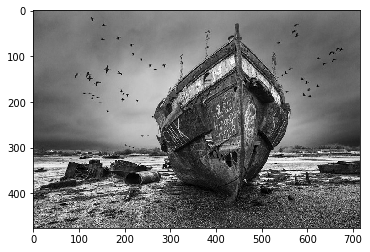

In [6]:
plt.imshow(img);

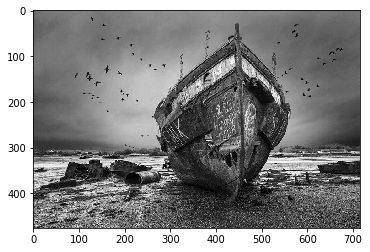

In [7]:
plt.imshow(q_img);

In [8]:
# part 2
def batch_reduce(folder, file_list, out_colors_list):
    # create folders
    if not os.path.exists('./{}/original'.format(folder)):
        os.makedirs('./{}/original'.format(folder))
    if not os.path.exists('./{}/quantized'.format(folder)):
        os.makedirs('./{}/quantized'.format(folder))
    for i in range(len(file_list)):
        # quantize image
        img = imread('./{}/{}'.format(folder, file_list[i]))
        q_img = quantize(img, out_colors_list[i])
        print('{} image(s) processed: {}'.format(i+1, file_list[i]))
        # save images
        imsave('./{}/original/{}.png'.format(folder, file_list[i]), img)
        imsave('./{}/quantized/{}.png'.format(folder, file_list[i]), q_img)

In [9]:
# part 3
batch_reduce('Quantization/images', ['bw.jpg', 'coffee.jpg', 'flowers.jpg', 'grayscale.jpg'], [32, 32, 32, 32])

1 image(s) processed: bw.jpg
2 image(s) processed: coffee.jpg
3 image(s) processed: flowers.jpg
4 image(s) processed: grayscale.jpg


# Clustering with PCA and Machine Learning

Create a simple custom pipeline that does the following with the survey data:

- train/test split using 67% of the data for the train
- perform PCA and select the number of components that retain at least 90% of the variance
- perform k-means clustering on the PCA training set (scki-kit learn) with 16 clusters
- apply the cluster labels to the training set
- fit the labeled training set using a Random Forest Classifier
- make predictions on the test set using both the k-means and rfc models
- compare the two model predictions using class-wise precision, recall, and f1

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [33]:
survey = responses.drop(['label16', 'label2'], axis=1)

In [34]:
# split
Xtrain, Xtest = train_test_split(survey, train_size=0.67, random_state=125)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [35]:
# PCA
pca = PCA()
pca.fit(Xtrain)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

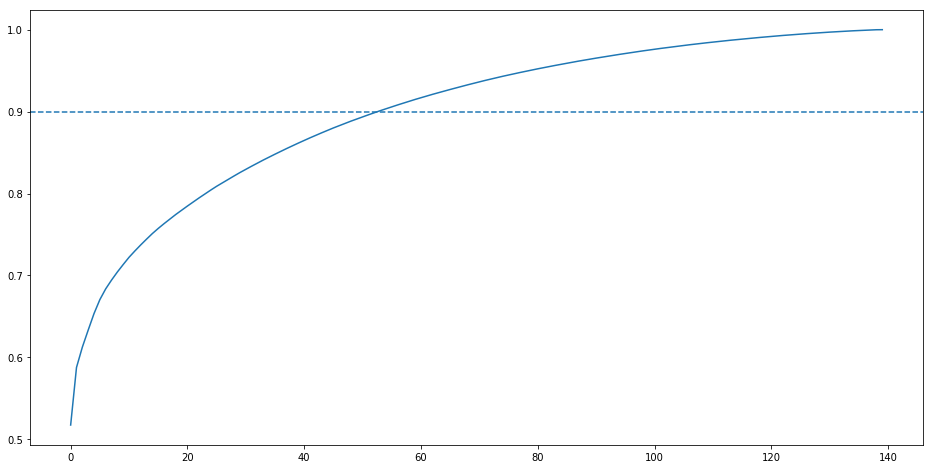

In [36]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.9, linestyle='--');

In [37]:
explained_var = np.cumsum(pca.explained_variance_ratio_)
n_comp = len(explained_var[explained_var < 0.9]) + 1

pca.set_params(n_components=n_comp)
Xtrain_red = pca.fit_transform(Xtrain)

In [38]:
# kmeans
kmeans = KMeans(n_clusters=16, random_state=147)
kmeans.fit(Xtrain_red)
ytrain = kmeans.predict(Xtrain_red)

In [39]:
# forest
rf = RandomForestClassifier(random_state=123)
rf.fit(Xtrain_red, ytrain)
ytrain_pred = rf.predict(Xtrain_red)

In [40]:
# score
print(classification_report(ytrain, ytrain_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        31
          1       1.00      0.97      0.99        36
          2       1.00      1.00      1.00        35
          3       1.00      1.00      1.00        14
          4       1.00      1.00      1.00         7
          5       1.00      1.00      1.00        21
          6       1.00      1.00      1.00        26
          7       1.00      1.00      1.00        29
          8       1.00      1.00      1.00        23
          9       0.98      1.00      0.99        58
         10       1.00      1.00      1.00        40
         11       1.00      1.00      1.00        22
         12       1.00      1.00      1.00        54
         13       1.00      1.00      1.00        19
         14       1.00      1.00      1.00        21
         15       1.00      1.00      1.00        23

avg / total       1.00      1.00      1.00       459



In [41]:
# try it out on test set
Xtest_red = pca.transform(Xtest)
ytest = kmeans.predict(Xtest_red)
ytest_pred = rf.predict(Xtest_red)
print(classification_report(ytest, ytest_pred))

             precision    recall  f1-score   support

          0       0.41      0.58      0.48        12
          1       0.51      0.70      0.59        27
          2       0.27      0.54      0.36        13
          3       0.20      0.33      0.25         3
          4       0.67      1.00      0.80         2
          5       0.17      0.14      0.15         7
          6       0.38      0.43      0.40         7
          7       0.54      0.39      0.45        18
          8       0.33      0.21      0.26        14
          9       0.67      0.93      0.78        28
         10       0.50      0.38      0.43        13
         11       0.50      0.62      0.56         8
         12       0.88      0.61      0.72        38
         13       0.75      0.27      0.40        11
         14       0.44      0.31      0.36        13
         15       0.80      0.31      0.44        13

avg / total       0.57      0.53      0.52       227

